# **CAT 🐱 & DOG 🐶 RECOGNIZATION MODEL USING DEEP NEURAL NETWORKS** 

![](https://myvegandreams.com/wp-content/uploads/2017/05/Cats-Be-Vegan-1024x682.jpg)

Image recogization has always been an excited field of Deep Learning. In this project, we will build a Deep Neural Networks model to distinguish cat and dog images. The dataset is acquired from the Kaggle competition 6 years ago.

### A quick introduction about the dataset

#### The Asirra data set
Web services are often protected with a challenge that's supposed to be easy for people to solve, but difficult for computers. Such a challenge is often called a CAPTCHA (Completely Automated Public Turing test to tell Computers and Humans Apart) or HIP (Human Interactive Proof). HIPs are used for many purposes, such as to reduce email and blog spam and prevent brute-force attacks on web site passwords.

Asirra (Animal Species Image Recognition for Restricting Access) is a HIP that works by asking users to identify photographs of cats and dogs. This task is difficult for computers, but studies have shown that people can accomplish it quickly and accurately. Many even think it's fun! Here is an example of the Asirra interface:

Asirra is unique because of its partnership with Petfinder.com, the world's largest site devoted to finding homes for homeless pets. They've provided Microsoft Research with over three million images of cats and dogs, manually classified by people at thousands of animal shelters across the United States. Kaggle is fortunate to offer a subset of this data for fun and research. 

#### Image recognition attacks
While random guessing is the easiest form of attack, various forms of image recognition can allow an attacker to make guesses that are better than random. There is enormous diversity in the photo database (a wide variety of backgrounds, angles, poses, lighting, etc.), making accurate automatic classification difficult. In an informal poll conducted many years ago, computer vision experts posited that a classifier with better than 60% accuracy would be difficult without a major advance in the state of the art. For reference, a 60% classifier improves the guessing probability of a 12-image HIP from 1/4096 to 1/459.

#### State of the art
The current literature suggests machine classifiers can score above 80% accuracy on this task. Therfore, Asirra is no longer considered safe from attack.  We have created this contest to benchmark the latest computer vision and deep learning approaches to this problem. Can you crack the CAPTCHA? Can you improve the state of the art? Can you create lasting peace between cats and dogs?

Okay, we'll settle for the former. 

## TABLE OF CONTENT

**1. Import Libraries and Data**
- Import Libraries
- Import Dataset
- Explore Dataset

**2. Preprocess Data**
- Dataset into Dataframe
- Split into Train and Validation Set
- Data Augmentation 

**3. Model: CNN**

**4. Alternative Model: MobileNetv2**

**5. Proceed on Test Set**

**6. Summary**

## 1. Import Libraries and Data

#### **Importing Libraries**

In [2]:
#import libraries
import os
from os import listdir
import numpy as np 
import pandas as pd

#DNN model builder
import tensorflow as tf
import keras
from keras import applications
from keras.preprocessing.image import ImageDataGenerator

#Visualizer
from matplotlib import pyplot as plt
from tqdm import tqdm

Using TensorFlow backend.


In [3]:
print(tf.__version__)

2.0.0


In [4]:
# !python3 -m pip install tensorflow==2.0.0 --user

In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
print(tf.__version__)

2.0.0


In [4]:
tf.test.is_gpu_available()

True

#### **Importing Dataset**

In [5]:
# import zipfile
# with zipfile.ZipFile("dogs-vs-cats.zip","r") as zip_ref:
#     zip_ref.extractall("dogs-vs-cats")

In [6]:
# with zipfile.ZipFile("dogs-vs-cats/train.zip","r") as zip_ref:
#     zip_ref.extractall("train")
# with zipfile.ZipFile("dogs-vs-cats/test1.zip","r") as zip_ref:
#     zip_ref.extractall("test1")

In [5]:
ROOT = '/home/jupyter/'

TRAIN_DIR = ROOT + 'train/train/'
TEST_DIR = ROOT + 'test1/test1/'

train_files = list(os.listdir(TRAIN_DIR))
test_files = list(os.listdir(TEST_DIR))

TRAIN_SIZE = len(train_files)
TEST_SIZE = len(test_files)

print('Number of train images: ', TRAIN_SIZE)
print('Number of test images: ', TEST_SIZE)
                 


Number of train images:  25000
Number of test images:  12500


Take a quick look at out data

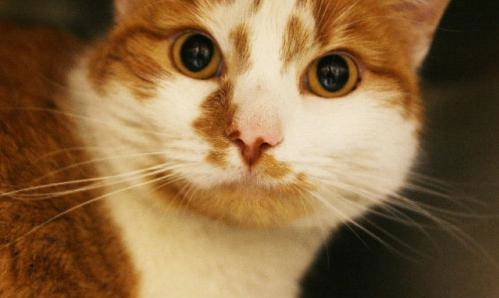

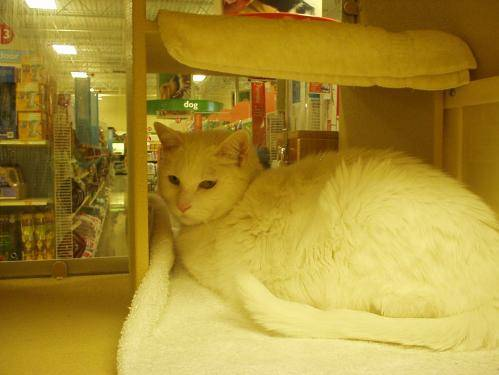

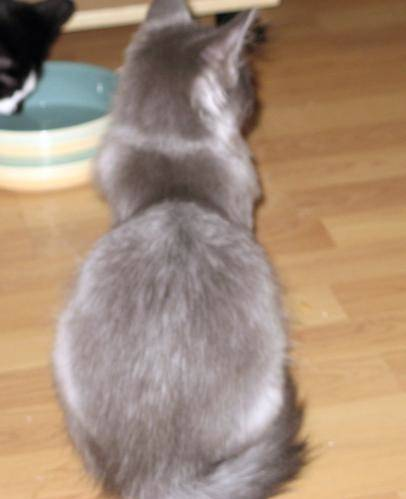

In [6]:
import IPython.display as display
import random 

for n in range(3):
    image_path = TRAIN_DIR + random.choice(train_files)
    display.display(display.Image(image_path))
    print()

## 2. Preprocess Data

### 2.1. Train Data into Dataframe

In [7]:
#Extract train label
train_labels = []
for file in train_files: 
    label = file.split('.')[0]
    label = {'cat': 0, 'dog' : 1}.get(label)
    train_labels.append(label)

#Add to dataframe
train_df = pd.DataFrame({
    'id' : train_files,
    'label' : train_labels
})

In [8]:
train_df.sample(5)

,id,label
24269,dog.4039.jpg,1
9523,dog.683.jpg,1
18604,cat.4675.jpg,0
21048,cat.7274.jpg,0
14023,dog.1226.jpg,1


### 2.2. Split into train and validation dataset

In [10]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(train_df, test_size = 0.1, random_state = 101)

In [11]:
print('Shape of train data: ', train_df.shape)
print('Shape of validation data: ', val_df.shape)

Shape of train data:  (22500, 2)
Shape of validation data:  (2500, 2)


### 2.3. Data Augmentation
Multiple augmentation steps will be done on train set.
On validation test, we only normalize image data from 0-255 to 0-1.

In [15]:
BATCH_SIZE = 256

IMAGE_WIDTH = 150
IMAGE_HEIGHT = 150 

#Augmentation setting
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 20,
                                   zoom_range = 0.15,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.15,
                                   horizontal_flip=True,
                                   fill_mode="nearest")

val_datagen = ImageDataGenerator(rescale = 1./255.)

#Train and valid generators
train_generator = train_datagen.flow_from_dataframe(
        train_df,
        TRAIN_DIR,
        x_col = 'id',
        y_col = 'label',
        target_size = (IMAGE_WIDTH, IMAGE_HEIGHT),
        class_mode = 'raw',
        batch_size = BATCH_SIZE 
)

val_generator = val_datagen.flow_from_dataframe(
        val_df,
        TRAIN_DIR,
        x_col = 'id',
        y_col = 'label',
        target_size = (IMAGE_WIDTH, IMAGE_HEIGHT),
        class_mode = 'raw',
        batch_size = BATCH_SIZE 
)

Found 22500 validated image filenames.
Found 2500 validated image filenames.


## 3. Modelling

### 3.1. Build

In [25]:
#Initiate hyperparameters
LEARNING_RATE = 0.001
DECAY = 0.0 
EPOCHS = 20

#Create model and optimizer
def create_model():
    model = tf.keras.models.Sequential([
    # the images were resized by ImageDataGenerator 150x150 with 3 bytes color
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2), 
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(), 
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    # since we have only 2 classes to predict we can use 1 neuron and sigmoid
    tf.keras.layers.Dense(1, activation='sigmoid')  
])
    #Setting up Optimizer
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0),
    loss='binary_crossentropy',
    metrics = ['accuracy'])
    
    return model

model = create_model()

In [26]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 15, 15, 128)      

In [28]:
#Setting up EarlyStopping
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                      mode='min',
                                      restore_best_weights=True, 
                                      verbose=1,
                                      patience=5)
#Setting up Checkpoint
checkpoint_path = "/home/jupyter/"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
# by default it saves the weights every epoch
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)


#Define step per epoch
steps_per_epoch = round(TRAIN_SIZE*(1 - 0.1)/BATCH_SIZE)
val_steps = round(TRAIN_SIZE*0.1/BATCH_SIZE)

In [29]:
%%time
#Load checkpoint
# model.load_weights(checkpoint_path)

#Fit data into model
history = model.fit_generator(train_generator,
                              validation_data = val_generator,
                              steps_per_epoch = steps_per_epoch,
                              validation_steps = val_steps,
                              epochs=EPOCHS,
                              callbacks = [es, cp_callback],
                              verbose = 1
                             )

Epoch 1/20
87/88 [============================>.] - ETA: 1s - loss: 0.6769 - accuracy: 0.5734
Epoch 00001: saving model to /home/jupyter/
88/88 [==============================] - 165s 2s/step - loss: 0.6773 - accuracy: 0.5729 - val_loss: 0.6562 - val_accuracy: 0.6112
Epoch 2/20
87/88 [============================>.] - ETA: 1s - loss: 0.6267 - accuracy: 0.6484
Epoch 00002: saving model to /home/jupyter/
88/88 [==============================] - 159s 2s/step - loss: 0.6265 - accuracy: 0.6485 - val_loss: 0.5565 - val_accuracy: 0.7324
Epoch 3/20
87/88 [============================>.] - ETA: 1s - loss: 0.5702 - accuracy: 0.7013
Epoch 00003: saving model to /home/jupyter/
88/88 [==============================] - 159s 2s/step - loss: 0.5691 - accuracy: 0.7021 - val_loss: 0.4968 - val_accuracy: 0.7536
Epoch 4/20
87/88 [============================>.] - ETA: 1s - loss: 0.5312 - accuracy: 0.7317
Epoch 00004: saving model to /home/jupyter/
88/88 [==============================] - 159s 2s/step - lo

### 3.2. Evaluate

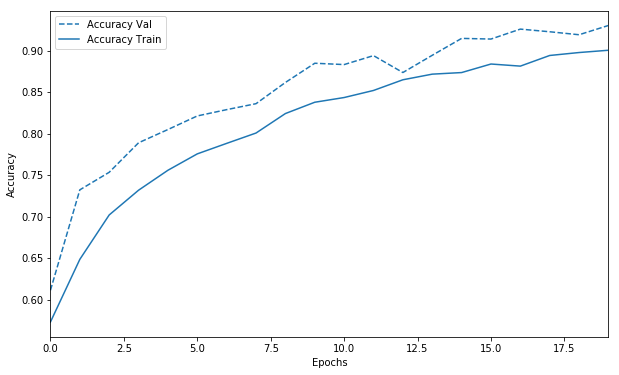

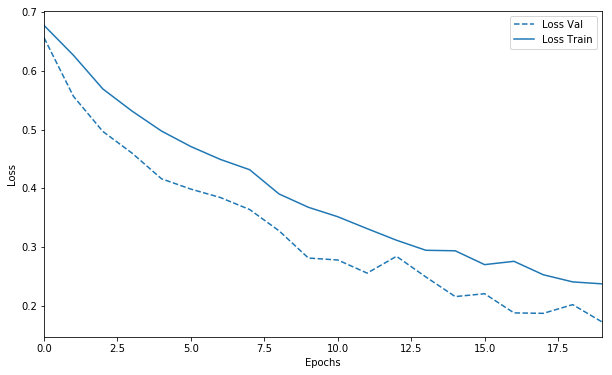

In [30]:
def plot_history(history, key='loss'):
    plt.figure(figsize=(10,6))

    val = plt.plot(history.epoch, history.history['val_'+key],
                    '--', label=key.title() +' Val')
    plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
                label=key.title() + ' Train')

    plt.xlabel('Epochs')
    plt.ylabel(key.replace('_',' ').title())
    plt.legend()

    plt.xlim([0,max(history.epoch)])

plot_history(history, key='accuracy')
plot_history(history, key='loss')

### 3.3. Export

In [31]:
model.save('nhan_catmodel_CNNAdam.h5')

## 4. Alternative Model

### 4.1. Build

In [19]:
#Initiate hyperparameters
LEARNING_RATE = 0.001
DECAY = 0.0 
EPOCHS = 20

from keras.layers import Dropout, Flatten, Dense,GlobalAveragePooling2D


#Create model and optimizer
def create_mobile_model():
    # build the MobileNetV2 network
    mobile_net = tf.keras.applications.MobileNetV2(input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3), include_top=False)
    mobile_net.trainable=False
    
    mobile_model = tf.keras.Sequential([mobile_net,
                                        tf.keras.layers.GlobalAveragePooling2D(),
                                        tf.keras.layers.Dense(2, activation = 'sigmoid')])
    
    #Setting up Optimizer
    mobile_model.compile(optimizer=tf.keras.optimizers.Adam(lr=LEARNING_RATE, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=DECAY),
                         loss='sparse_categorical_crossentropy',
                         metrics = ['accuracy'])

    return mobile_model

mobile_model = create_mobile_model()

#Review model architect
mobile_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [20]:
#Setting up EarlyStopping
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                      mode='min',
                                      restore_best_weights=True, 
                                      verbose=1,
                                      patience=5)
#Setting up Checkpoint
checkpoint_path = "/home/jupyter/CheckPointMobile"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
# by default it saves the weights every epoch
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)


#Define step per epoch
steps_per_epoch = round(TRAIN_SIZE*(1 - 0.1)/BATCH_SIZE)
val_steps = round(TRAIN_SIZE*0.1/BATCH_SIZE)

In [21]:
%%time
#Load checkpoint
# model.load_weights(checkpoint_path)

#Fit data into model
mobile_history = mobile_model.fit_generator(train_generator,
                                            validation_data = val_generator,
                                            steps_per_epoch = steps_per_epoch,
                                            validation_steps = val_steps,
                                            epochs=EPOCHS,
                                            callbacks = [es, cp_callback],
                                            verbose = 1
                                            )

Epoch 1/20
87/88 [============================>.] - ETA: 3s - loss: 0.3238 - accuracy: 0.8483
Epoch 00001: saving model to /home/jupyter/CheckPointMobile
88/88 [==============================] - 367s 4s/step - loss: 0.3225 - accuracy: 0.8488 - val_loss: 0.1919 - val_accuracy: 0.9372
Epoch 2/20
87/88 [============================>.] - ETA: 1s - loss: 0.2112 - accuracy: 0.9097
Epoch 00002: saving model to /home/jupyter/CheckPointMobile
88/88 [==============================] - 144s 2s/step - loss: 0.2109 - accuracy: 0.9097 - val_loss: 0.1985 - val_accuracy: 0.9388
Epoch 3/20
87/88 [============================>.] - ETA: 1s - loss: 0.1970 - accuracy: 0.9164
Epoch 00003: saving model to /home/jupyter/CheckPointMobile
88/88 [==============================] - 154s 2s/step - loss: 0.1973 - accuracy: 0.9164 - val_loss: 0.2065 - val_accuracy: 0.9396
Epoch 4/20
87/88 [============================>.] - ETA: 1s - loss: 0.1869 - accuracy: 0.9213
Epoch 00004: saving model to /home/jupyter/CheckPointM

### 4.2. Evaluate

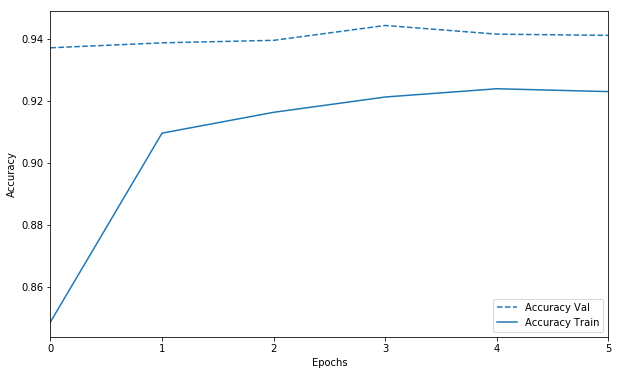

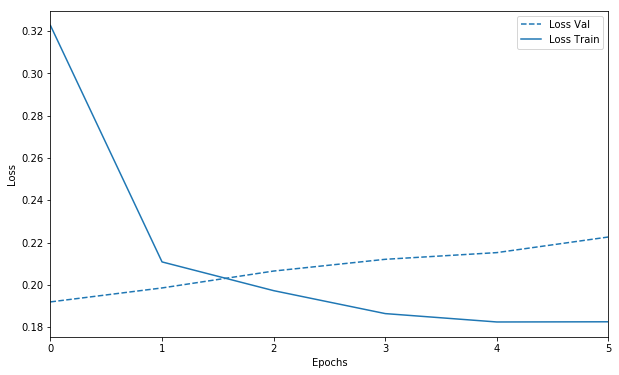

In [23]:
def plot_history(history, key='loss'):
    plt.figure(figsize=(10,6))

    val = plt.plot(history.epoch, history.history['val_'+key],
                    '--', label=key.title() +' Val')
    plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
                label=key.title() + ' Train')

    plt.xlabel('Epochs')
    plt.ylabel(key.replace('_',' ').title())
    plt.legend()

    plt.xlim([0,max(history.epoch)])

plot_history(mobile_history, key='accuracy')
plot_history(mobile_history, key='loss')

### 4.3. Export 

In [25]:
mobile_model.save('nhan_catmodel_MobileAdam.h5')

## 5. Proceed on Test Set

### 5.1. Predict
- Add test set into dataframe
- Preprocess test-set into the shape 150x150 and normalize its pixel values.
- Load our best model (MobileNetv2) and predict test set. 

In [28]:
# Test data into dataframe
test_df = pd.DataFrame({'id' : test_files})
test_df.sample(5)

,id
3998,5999.jpg
5425,1999.jpg
9336,296.jpg
37,6195.jpg
9910,2931.jpg


In [44]:
def test_predict(test_data):
    #Preprocess test-set
    test_datagen = ImageDataGenerator(rescale = 1./255.)
    test_generator = val_datagen.flow_from_dataframe(test_data,
                                                     TEST_DIR,
                                                     x_col = 'id',
                                                     y_col = None,
                                                     target_size = (IMAGE_WIDTH, IMAGE_HEIGHT),
                                                     class_mode = None,
                                                     batch_size = BATCH_SIZE 
                                                     )
    #Load model and predict
    test_steps = round(TEST_SIZE/BATCH_SIZE)
    test_predictions = mobile_model.predict_generator(test_generator,
                                                      steps=test_steps,
                                                      verbose=1)
    
    predicted_class = np.argmax(test_predictions,axis=1)
    
    return predicted_class 

In [45]:
predict = test_predict(test_df)
predict

Found 12500 validated image filenames.
49/49 [==============================] - 32s 653ms/step


array([1, 0, 0, ..., 1, 0, 0])

### 5.2. Submission:
Add predictions into test_df, correspond with Kaggle submission sample. 

In [65]:
# Adding 'predict' column
submission = test_df.copy()
submission['label'] = predict

In [66]:
# Create 'id' column
submission['id'] = test_df['id'].str.split('.').str[0]
submission['id'] = submission['id'].astype('int')

In [76]:
# Sort id column
submission = submission.sort_values(by = ['id'], ascending = True)

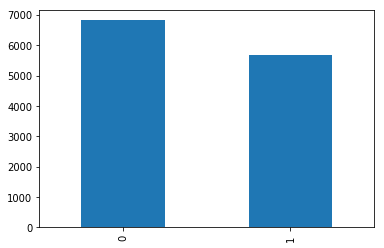

In [74]:
submission.label.value_counts().plot.bar()

In [77]:
# Save submission file
submission.to_csv('predict_catvsdog.csv', index = False)

## 6. Summary

The challenge is to build a Deep Neural Networks to distinguish Cat and Dog image. In this project, we offer two solution models (CNN and MobileNetv2) with data augmentation preprocessing before fitting into the model. On each model, we experiment different optimizers and compare the results. 

With hyperparameter at:
```
LEARNING_RATE = 0.001
DECAY = 0.0 
BATCH_SIZE = 256
EPOCHS = 20
```

- CNN model with SGD optimizer returns train accuracy -- 0.61 and validation accuracy -- 0.59. 
- CNN model with RMSprop optimizer returns train accuracy -- 0.88 and validation accuracy -- 0.91. 
- CNN model with Adam optimizer returns train accuracy -- 0.90 and validation accuracy -- 0.93.
- MobileNetv2 model with Adam optimizer returns train accuracy -- 0.9231 and validation accuracy -- 0.9412. (Early-stopped at 6th epoch)

Our model reaches its best score at **0.93** on validation set with **MobileNetv2** and **Adam optimizer**. 